In [2]:
%matplotlib inline
import sys
import os
sys.path.append('/global/homes/s/schutt20/py_modules/my_utils')
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import fitsio
from toFocal import toFocal, toFocalPixel, toFocalArcmin
import plot_utils

## PIFF V3 FULL WIDE FIELD SURVEY

In [3]:
# set some plotting defaults
mpl.rc(('lines', 'axes') , linewidth=2)
mpl.rc(('xtick', 'ytick'), labelsize=18)
mpl.rc(('xtick.major', 'ytick.major'), width=2)
mpl.rcParams['axes.labelsize'] = 23
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['mathtext.fontset'] = 'stix'
# mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['legend.fontsize'] = 18
mpl.rcParams['axes.titlesize'] = 23
mpl.rcParams['font.size'] = 23
mpl.rcParams["figure.facecolor"] = 'white'
mpl.rcParams["axes.facecolor"] = 'white'

In [4]:
# plt_dir = '/global/cfs/cdirs/des/schutt20/plots/des-y6-psf/fp'
plt_dir = '/global/cscratch1/sd/schutt20/y6a2_piff_testing/plots_temp/des-y6-psf/fp'

In [5]:
#get band indices into Y6 catalog to minimize memory usage
band = 'g'
ver = '1'
filestem = 'y6a2_piff_v3_allres_v3'

y6_idx_file = '/global/cscratch1/sd/schutt20/y6a2_piff_testing/catalogs/%s_%s_idx.txt'%(filestem, band)

with open(y6_idx_file, 'r') as f:
    y6_idx_arr = np.fromfile(y6_idx_file, int)

In [6]:
print(y6_idx_arr, len(y6_idx_arr))

[        0         1         2 ... 138045862 138045863 138045864] 25895666


In [7]:
y6piff = '/global/cscratch1/sd/schutt20/y6a2_piff_testing/catalogs/%s_collated.fits'%filestem

y6piff_fits = fitsio.FITS(y6piff)

In [8]:
y6piff_fits[1]


  file: /global/cscratch1/sd/schutt20/y6a2_piff_testing/catalogs/y6a2_piff_v3_allres_v3_collated.fits
  extension: 1
  type: BINARY_TBL
  rows: 138045977
  column info:
    EXPNUM              i8  
    CCDNUM              i2  
    BAND                S4  
    MJD_OBS             f8  
    TELRA              S60  
    TELDEC             S60  
    NSTAR               i4  
    NREMOVED            i4  
    EXP_STAR_T_MEAN     f8  
    EXP_STAR_T_STD      f8  
    STAR_T_MEAN         f8  
    STAR_T_STD          f8  
    FWHM_CEN            f8  
    PSF_FWHM            f8  
    FLAG                i4  
    COADD_OBJECT_ID     i8  
    RA                  f8  
    DEC                 f8  
    U                   f8  
    V                   f8  
    X                   f8  
    Y                   f8  
    SNR                 f8  
    FLUX                f8  
    BDF_T               f8  
    T_DATA              f8  
    T_MODEL             f8  
    G1_DATA             f8  
    G1_MODEL      

In [9]:
y6piff_band = y6piff_fits[1][y6_idx_arr]

In [10]:
rng = np.random.default_rng(1234)
nentries = len(y6_idx_arr)
nstar = int(1e7)
idx_sample = rng.integers(low=0, high=nentries, size=nstar) #high is exclusive
y6piff_band = y6piff_band[idx_sample]

In [11]:
y6uu, y6vv = toFocalArcmin(y6piff_band['CCDNUM'], y6piff_band['X'], y6piff_band['Y'])

In [11]:
# calc residuals
y6_dT = y6piff_band['T_DATA']-y6piff_band['T_MODEL']
y6_de1 = y6piff_band['G1_DATA']-y6piff_band['G1_MODEL']
y6_de2 = y6piff_band['G2_DATA']-y6piff_band['G2_MODEL']

# using model values as denominator (less noisy)
y6_dT_frac = (y6piff_band['T_DATA']-y6piff_band['T_MODEL'])/y6piff_band['T_MODEL']
y6_de1_frac = (y6piff_band['G1_DATA']-y6piff_band['G1_MODEL'])/y6piff_band['G1_MODEL']
y6_de2_frac = (y6piff_band['G2_DATA']-y6piff_band['G2_MODEL'])/y6piff_band['G2_MODEL']

In [12]:
print(np.mean(y6_dT),
      np.mean(y6_dT_frac),
      np.mean(y6_de1),
      np.mean(y6_de2))
print(np.std(y6_dT),
      np.std(y6_dT_frac),
      np.std(y6_de1),
      np.std(y6_de2))

-0.0002244164905302185 -0.0006801652426500443 8.258047384656472e-06 -2.7306992036831225e-05
0.013119395737033196 0.03231297012325051 0.016158392354803763 0.016033668352660402


In [12]:
def plot_fp_on_ax(ax, hexbin_kw):
    cset = ax.hexbin(**hexbin_kw)
    ax.set_aspect('equal')
    ax.set_box_aspect(1)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    return cset

In [13]:
def plot_fp_hexbin(plot_dict):
    f, axs = plt.subplots(plot_dict['subplot_dims'][0], plot_dict['subplot_dims'][1], figsize=plot_dict['figsize'])
    try: # handles plotting N datasets on N axes
        for i, ax in enumerate(axs):
            hexbin_kw['C'] = plot_dict['data'][i]
            ax.set_title(plot_dict['title'][i])
            cset1 = plot_fp_on_ax(ax, plot_dict['hexbin_kw'])
            if i > 0:
                left, bottom, width, height = axs[i-1].get_position().bounds
                pad = 0.1
                bounds = [left + width*(1 + pad), bottom, width, height]
                ax.set_position(bounds)
    except TypeError:
        hexbin_kw['C'] = plot_dict['data']
        axs.set_title(plot_dict['title'])
        cset1 = plot_fp_on_ax(axs, plot_dict['hexbin_kw'])

    cbar1 = plot_utils.pretty_colorbar(cset1, cbar_kw=plot_dict['cbar_kw'], cbax_kw=plot_dict['cbax_kw'])

In [14]:
# set up plotting defaults
hexbin_kw = {'x':-y6vv, 'y':-y6uu, 'C':None, 'gridsize':500, 'mincnt':1, 'vmin':-1, 'vmax':1, 'cmap':'RdBu_r'}
cbar_kw = {}
cbax_kw = {'ylabel': None}
plot_kw = {'subplot_dims': (1,1), 'figsize': (9,8), 'data':None, 'title':None, 'hexbin_kw': hexbin_kw, 'cbar_kw': cbar_kw, 'cbax_kw': cbax_kw}

In [15]:
print(plot_kw)

{'subplot_dims': (1, 1), 'figsize': (9, 8), 'data': None, 'title': None, 'hexbin_kw': {'x': array([ 24.60465595,   9.10560829, -26.5088389 , ...,  32.56551335,
        14.52392625,  11.8091862 ]), 'y': array([ 37.74769954,  42.56344011, -53.84275763, ..., -35.10850955,
        38.48456617,  -5.15771524]), 'C': None, 'gridsize': 500, 'mincnt': 1, 'vmin': -1, 'vmax': 1, 'cmap': 'RdBu_r'}, 'cbar_kw': {}, 'cbax_kw': {'ylabel': None}}


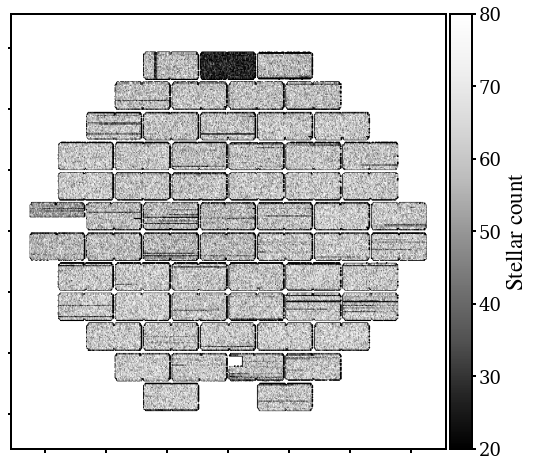

In [15]:
#stellar count
plttype = 'nstar'
pltname = '%s_%s_%s_%s.pdf'%(filestem, band, plttype, ver)
filename = os.path.join(plt_dir, pltname)
# print(filename)

# set plotting config
hexbin_kw['vmin'] = 20
hexbin_kw['vmax'] = 80
hexbin_kw['cmap'] = 'Greys_r'
cbax_kw['ylabel'] = r'$\rm Stellar~count$'

plot_fp_hexbin(plot_kw)
plt.savefig(filename, bbox_inches='tight', dpi=100)

0.6147739388466236


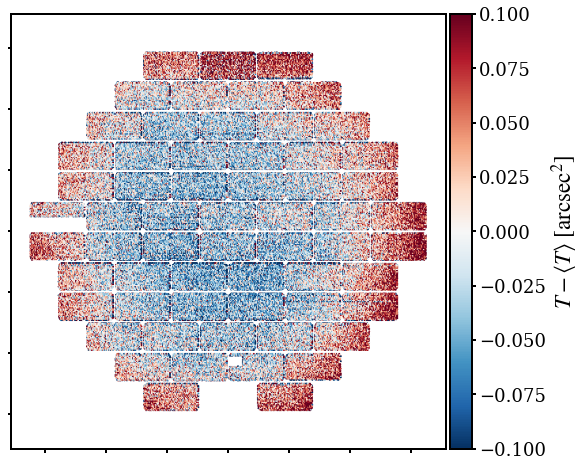

In [16]:
# absolute T, e1, e2
#stellar count
plttype = 'T'
ver = 'test'
pltname = '%s_%s_%s_%s.pdf'%(filestem, band, plttype, ver)
filename = os.path.join(plt_dir, pltname)
# print(filename)
# set plotting config
vmax = 0.1
mean_T = np.mean(y6piff_band['T_DATA'])
print(mean_T)
hexbin_kw['vmin'] = -vmax
hexbin_kw['vmax'] = vmax
plot_kw['data'] = y6piff_band['T_DATA'] - mean_T
hexbin_kw['cmap'] = 'RdBu_r'
cbax_kw['ylabel'] = r'$T-\left<T\right>~[{\rm arcsec}^2]$'

plot_fp_hexbin(plot_kw)
plt.savefig(filename, bbox_inches='tight', dpi=100)

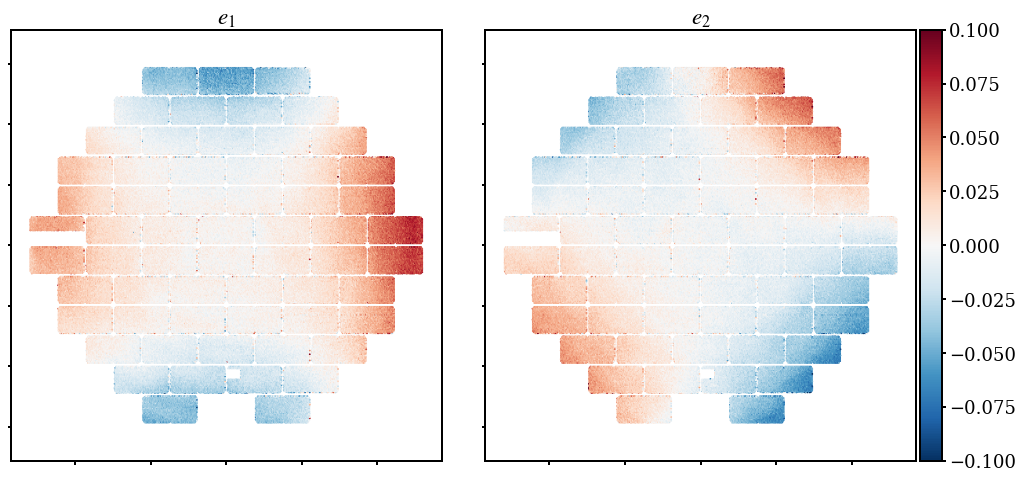

In [33]:
# absolute e1 and e2
plttype = 'e1e2'
pltname = '%s_%s_%s_%s.pdf'%(filestem, band, plttype, ver)
filename = os.path.join(plt_dir, pltname)
vmax = 0.1
plot_kw['subplot_dims'] = (1,2)
plot_kw['figsize'] = (17,8)
plot_kw['data'] = [y6piff_band['G1_DATA'], y6piff_band['G2_DATA']]
plot_kw['title'] = [r'$e_1$', r'$e_2$']
hexbin_kw['vmin'] = -vmax
hexbin_kw['vmax'] = vmax
hexbin_kw['cmap'] = 'RdBu_r'
cbax_kw['ylabel'] = None

plot_fp_hexbin(plot_kw)
plt.savefig(filename, bbox_inches='tight', dpi=100)

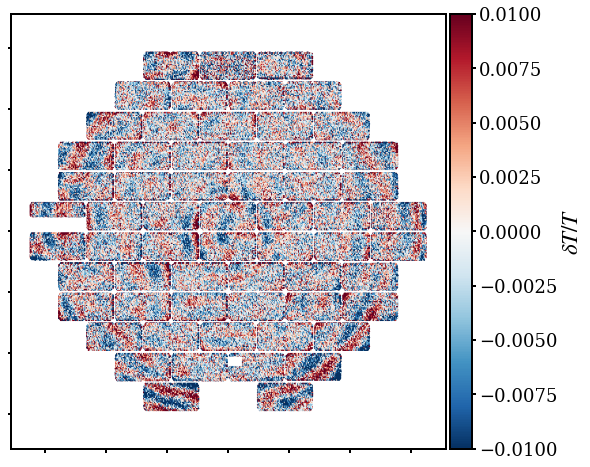

In [18]:
# T residuals
plttype = 'dTfrac'
pltname = '%s_%s_%s_%s.pdf'%(filestem, band, plttype, ver)
filename = os.path.join(plt_dir, pltname)

# set plotting config
vmax = 0.01
plot_kw['data'] = y6_dT_frac
plot_kw['title'] = None
hexbin_kw['vmin'] = -vmax
hexbin_kw['vmax'] = vmax
hexbin_kw['cmap'] = 'RdBu_r'
cbax_kw['ylabel'] = r'$\delta T/T$'

plot_fp_hexbin(plot_kw)
plt.savefig(filename, bbox_inches='tight', dpi=100)

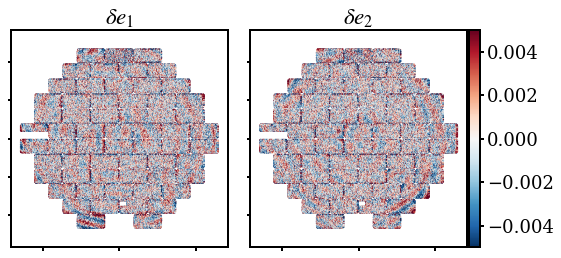

In [19]:
# e1 and e2 residuals
plttype = 'de'
pltname = '%s_%s_%s_%s.pdf'%(filestem, band, plttype, ver)
filename = os.path.join(plt_dir, pltname)
vmax = 0.005
plot_kw['subplot_dims'] = (1,2)
plot_kw['figsize'] = (9,4)
plot_kw['data'] = [y6_de1, y6_de2]
plot_kw['title'] = [r'$\delta e_1$', r'$\delta e_2$']
hexbin_kw['vmin'] = -vmax
hexbin_kw['vmax'] = vmax
hexbin_kw['cmap'] = 'RdBu_r'
cbax_kw['ylabel'] = None

plot_fp_hexbin(plot_kw)
plt.savefig(filename, bbox_inches='tight', dpi=100)

### Color dependence on FP

In [20]:
# y3_gi = y3piff_band['GI_COLOR']
if band == 'z':
    color = 'IZ_COLOR'
else:
    color = 'GI_COLOR'
y6_gi = y6piff_band[color]

In [21]:
print(len(y6_gi))

10000000


In [22]:
def compute_color_quant_idxs(color_cat, q=(0.25, 0.75), cmin=0., cmax=3.5):
    
    mask = (color_cat > cmin) & (color_cat < cmax)
    mcat = color_cat[mask]
    quants = np.quantile(mcat, q)
    # quant_75 = np.quantile(color_cat, 0.75)
    color_bins = []
    for i, quant in enumerate(quants):
        if i == 0:
            low = cmin
        else:
            low = hi
        if i < (len(quants)-1):
            hi = quant
            color_bins.append((low, hi))

        else:
            hi = quant
            color_bins.append((low, hi))
            # add last bin
            low = hi
            hi = cmax
            color_bins.append((low, hi))
        
    print(color_bins)

    band_idxs = [(color_cat > color_bins[0][0]) & (color_cat < color_bins[0][1]),
                 (color_cat > color_bins[1][0]) & (color_cat < color_bins[1][1]),
                 (color_cat > color_bins[2][0]) & (color_cat < color_bins[2][1])]

    return color_bins, band_idxs

In [23]:
def compute_color_fixed_idxs(color_cat, bins):
    color_bins = bins
    print(color_bins)

    band_idxs = [(color_cat > color_bins[0][0]) & (color_cat < color_bins[0][1]),
           (color_cat > color_bins[1][0]) & (color_cat < color_bins[1][1]),
           (color_cat > color_bins[2][0]) & (color_cat < color_bins[2][1])]

    return color_bins, band_idxs

In [24]:
# y3_color_bins, y3_band_idxs = compute_color_quant_idxs(y3_gi)
if band == 'z':
    cmax = 0.7
else:
    cmax = 3.5
color_bins, band_idxs = compute_color_quant_idxs(y6_gi, cmax=cmax)

# fixed_bins = [(0., 0.7), (0.7, 2.25), (2.25, 3.5)]
# y3_color_bins, y3_band_idxs = compute_color_fixed_idxs(y3_gi, fixed_bins)
# y6_color_bins, y6_band_idxs = compute_color_fixed_idxs(y6_gi, fixed_bins)

[(0.0, 0.1347775161266327), (0.1347775161266327, 0.4922807216644287), (0.4922807216644287, 0.7)]


In [25]:
split_cats = [y6piff_band[band_idxs[0]], y6piff_band[band_idxs[1]], y6piff_band[band_idxs[2]]]

In [26]:
for ccat in split_cats:
    print(len(ccat))
print(split_cats[0].dtype)

2499999
4999996
2499999
[('EXPNUM', '>i8'), ('CCDNUM', '>i2'), ('BAND', '<U4'), ('MJD_OBS', '>f8'), ('TELRA', '<U60'), ('TELDEC', '<U60'), ('NSTAR', '>i4'), ('NREMOVED', '>i4'), ('EXP_STAR_T_MEAN', '>f8'), ('EXP_STAR_T_STD', '>f8'), ('STAR_T_MEAN', '>f8'), ('STAR_T_STD', '>f8'), ('FWHM_CEN', '>f8'), ('PSF_FWHM', '>f8'), ('FLAG', '>i4'), ('COADD_OBJECT_ID', '>i8'), ('RA', '>f8'), ('DEC', '>f8'), ('U', '>f8'), ('V', '>f8'), ('X', '>f8'), ('Y', '>f8'), ('SNR', '>f8'), ('FLUX', '>f8'), ('BDF_T', '>f8'), ('T_DATA', '>f8'), ('T_MODEL', '>f8'), ('G1_DATA', '>f8'), ('G1_MODEL', '>f8'), ('G2_DATA', '>f8'), ('G2_MODEL', '>f8'), ('GI_COLOR', '>f8'), ('IZ_COLOR', '>f8'), ('G_MAG', '>f8'), ('R_MAG', '>f8'), ('I_MAG', '>f8'), ('Z_MAG', '>f8'), ('K_MAG', '>f8'), ('FLAG_COLOR', '>i4'), ('GAIA_STAR', '>i4'), ('GAIA_SOURCE_ID', '>i8'), ('VHS_OBJ', '>i4'), ('VHS_SOURCEID', '>i8')]


In [27]:
# cmin = 0.
# cmax = 3.5

# #compute color-split catalogs by 25-75 quantile splits
# quant_25 = np.quantile(gi_match, 0.25)
# quant_75 = np.quantile(gi_match, 0.75)

# band_cbins = [(0., quant_25), (quant_25, quant_75), (quant_75, cmax)]
# print(band_cbins)

# band_idxs = [(gi_match > band_cbins[0][0]) & (gi_match < band_cbins[0][1]),
#            (gi_match > band_cbins[1][0]) & (gi_match < band_cbins[1][1]),
#            (gi_match > band_cbins[2][0]) & (gi_match < band_cbins[2][1])]

# gi_splits = [gi_match[band_idxs[0]], gi_match[band_idxs[1]], gi_match[band_idxs[2]]]
# band_cats = [y3piff_match[band_idxs[0]], y3piff_match[band_idxs[1]], y3piff_match[band_idxs[2]]]

In [28]:
# y3uu, y3vv = toFocalPixel(y3piff_g['ccd'], y3piff_g['x'], y3piff_g['y'])
# y6uu, y6vv = toFocalPixel(y6piff_g['CCDNUM'], y6piff_g['X'], y6piff_g['Y'])
# print(min(y3uu), max(y3uu), min(y3vv), max(y3vv))
print(min(y6uu), max(y6uu), min(y6vv), max(y6vv))

-58.69453168229908 58.694803427469495 -64.84303751219836 64.84309759406645


(array([ 526489.,  886917., 1117058., 1232046., 1218594., 1299676.,
        1229486., 1139650.,  892801.,  457283.]),
 array([-5.86945317e+01, -4.69555982e+01, -3.52166647e+01, -2.34777311e+01,
        -1.17387976e+01,  1.35872585e-04,  1.17390694e+01,  2.34780029e+01,
         3.52169364e+01,  4.69558699e+01,  5.86948034e+01]),
 <BarContainer object of 10 artists>)

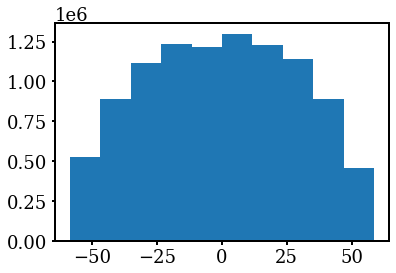

In [29]:
fig = plt.figure()
plt.hist(y6uu)

In [30]:
# def calc_2dbinned_res(shape_cat, res_type='T', year='Y6', nbins=100, xrange=59, yrange=65):
#     if year == 'Y6':
#         xx = 'X'
#         yy = 'Y'
#         ccd = 'CCDNUM'
#         data_t = 'T_DATA'
#         model_t = 'T_MODEL'
#         data_e1 = 'G1_DATA'
#         model_e1 = 'G1_MODEL'
#         data_e2 = 'G2_DATA'
#         model_e2 = 'G2_MODEL'
#     elif year == 'Y3':
#         xx = 'x'
#         yy = 'y'
#         ccd = 'ccd'
#         data_t = 'obs_T'
#         model_t = 'piff_T'
#         data_e1 = 'obs_e1'
#         model_e1 = 'piff_e1'
#         data_e2 = 'obs_e2'
#         model_e2 = 'piff_e2'
    
#     uu, vv = toFocalArcmin(shape_cat[ccd], shape_cat[xx], shape_cat[yy])
    
#     counts, ubins, vbins = np.histogram2d(uu, vv, bins=(nbins, nbins),
#                                           range=[[-xrange,xrange],[-yrange,yrange]])
        
#     if res_type == 'T':
#         dres = shape_cat[data_t] - shape_cat[model_t]
#     if res_type == 'Tfrac':
#         dres = (shape_cat[data_t] - shape_cat[model_t])/shape_cat[model_t]
#     elif res_type == 'e1':
#         dres = shape_cat[data_e1] - shape_cat[model_e1]
#     elif res_type == 'e2':
#         dres = shape_cat[data_e2] - shape_cat[model_e2]
#     elif res_type == 'e1+e2':
#         dres = ((shape_cat[data_e1] - shape_cat[model_e1]) +
#                 (shape_cat[data_e2] - shape_cat[model_e2]))
#     elif res_type == 'e1+e2_sq':
#         dres = np.sqrt((shape_cat[data_e1] - shape_cat[model_e1])**2 +
#                        (shape_cat[data_e2] - shape_cat[model_e2])**2)
#     else:
#         print('Invalid residual type provided.')
    
#     res_bin, _, _ = np.histogram2d(uu, vv, weights=dres, bins=(ubins, vbins))

#     res_bin = np.ma.masked_rray(res_bin, counts < 1)
    
#     return ubins, vbins, counts, res_bin

In [31]:
# def plot_2dbinned_res(ubins, vbins, counts, resbins, ax, title, vmin=None, vmax=None, restype= 'T', label=None, cbar=False):
#     with np.errstate(divide='ignore', invalid='ignore'):  # suppress possible divide-by-zero warnings
        
#         dres = resbins / counts

#         if vmin == None:
#             vmin = np.nanmin(dres)
#         if vmax == None:
#             vmax = np.nanmax(dres)
        
#         cm = ax.pcolormesh(ubins, vbins, dres, vmin=vmin, vmax=vmax,
#                                cmap='RdBu_r', label=label)

#     if restype == 'T':
#         cbarlabel = r'$\delta T \quad [\rm{arcsec}^2]$'
#     elif (restype == 'e1') | (restype == 'e2'):
#         cbarlabel = r'$\delta %s$'%restype
#     elif restype == 'e1+e2':
#         cbarlabel = r'$\delta e1 + \delta e2$'
#     elif restype == 'e1+e2_sq':
#         cbarlabel = r'$\sqrt{\delta e1^2 + \delta e2^2}$'
    
    
#     if cbar == True:
        
#         cbar = plot_utils.pretty_colorbar(cm, cbax_kw={'ylabel': cbarlabel, 'fontsize': 22})
#         # cbar.set_label(cbarlabel, fontsize=22)
#     # ax.set_xlabel(r'$u \quad \rm{[arcmin]}$', fontsize=22)
#     # ax.set_ylabel(r'$v \quad \rm{[arcmin]}$', fontsize=22)
#     ax.set_title(title, fontsize=18)

In [32]:
def calc_res(shape_cat, res_type='T', year='Y6', nbins=500):
    if year == 'Y6':
        xx = 'X'
        yy = 'Y'
        ccd = 'CCDNUM'
        data_t = 'T_DATA'
        model_t = 'T_MODEL'
        data_e1 = 'G1_DATA'
        model_e1 = 'G1_MODEL'
        data_e2 = 'G2_DATA'
        model_e2 = 'G2_MODEL'
    elif year == 'Y3':
        xx = 'x'
        yy = 'y'
        ccd = 'ccd'
        data_t = 'obs_T'
        model_t = 'piff_T'
        data_e1 = 'obs_e1'
        model_e1 = 'piff_e1'
        data_e2 = 'obs_e2'
        model_e2 = 'piff_e2'
    
    uu, vv = toFocalArcmin(shape_cat[ccd], shape_cat[xx], shape_cat[yy])

        
    if res_type == 'T':
        dres = shape_cat[data_t] - shape_cat[model_t]
    elif res_type == 'Tfrac':
        dres = (shape_cat[data_t] - shape_cat[model_t])/shape_cat[model_t]
    elif res_type == 'e1':
        dres = shape_cat[data_e1] - shape_cat[model_e1]
    elif res_type == 'e2':
        dres = shape_cat[data_e2] - shape_cat[model_e2]
    elif res_type == 'e1+e2':
        dres = ((shape_cat[data_e1] - shape_cat[model_e1]) +
                (shape_cat[data_e2] - shape_cat[model_e2]))
    elif res_type == 'de1+de2_sq':
        dres = np.sqrt((shape_cat[data_e1] - shape_cat[model_e1])**2 +
                       (shape_cat[data_e2] - shape_cat[model_e2])**2)
    elif res_type == 'e1+e2_sq':
        dres = (np.sqrt((shape_cat[data_e1])**2 + (shape_cat[data_e2])**2)
                - np.sqrt((shape_cat[model_e1])**2 + (shape_cat[model_e2])**2))
    else:
        print('Invalid residual type provided: ', res_type)
    
    return uu, vv, dres

In [33]:
res_types = ['T', 'Tfrac', 'e1', 'e2', 'e1+e2', 'de1+de2_sq', 'e1+e2_sq']
res_texs = [r'$\delta T$', r'$\delta T/T$', r'$\delta e_1$', r'$\delta e_2$', r'$\delta e_1 + \delta e_2$', r'$\sqrt{\delta e_1^2 + \delta e_2^2}$', r'$\delta\sqrt{e_1^2 + e_2^2}$']
v_list = [0.01, 0.01, 0.005, 0.005, 0.01, 0.025, 0.01]

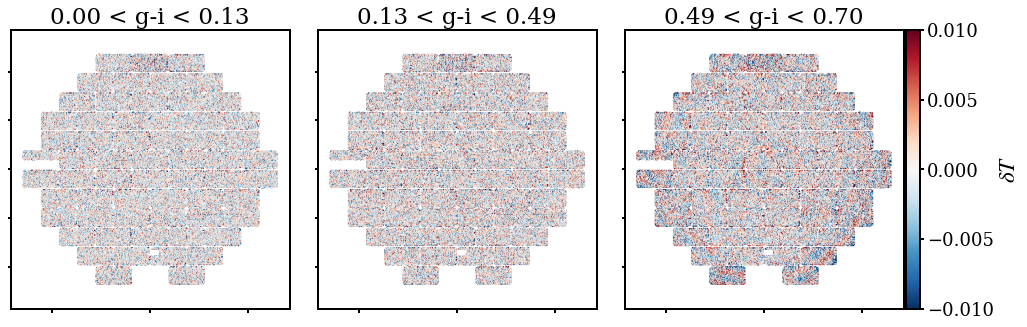

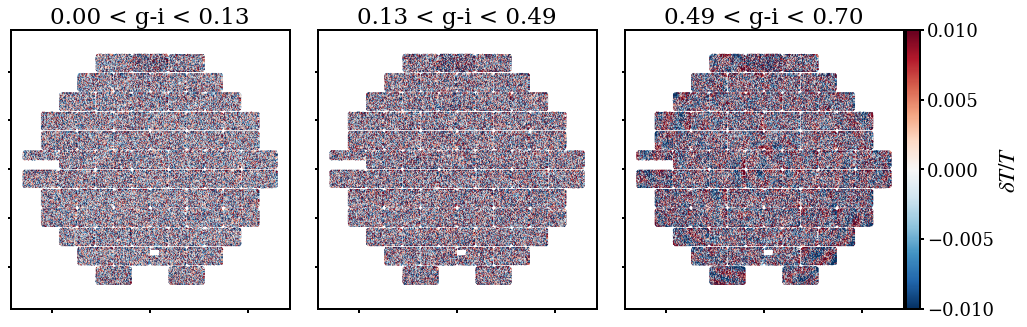

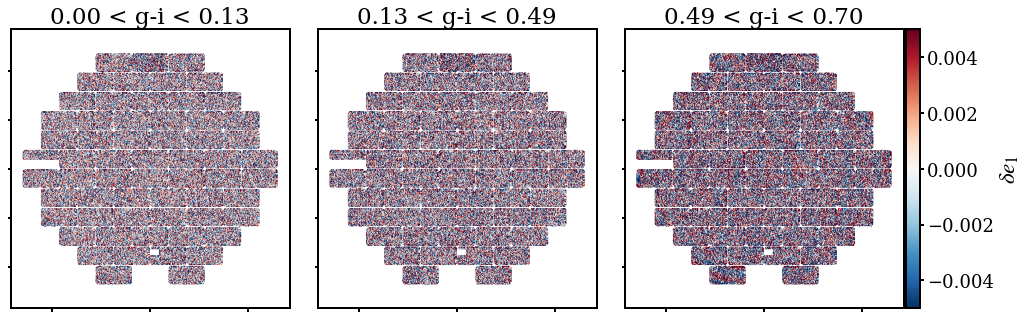

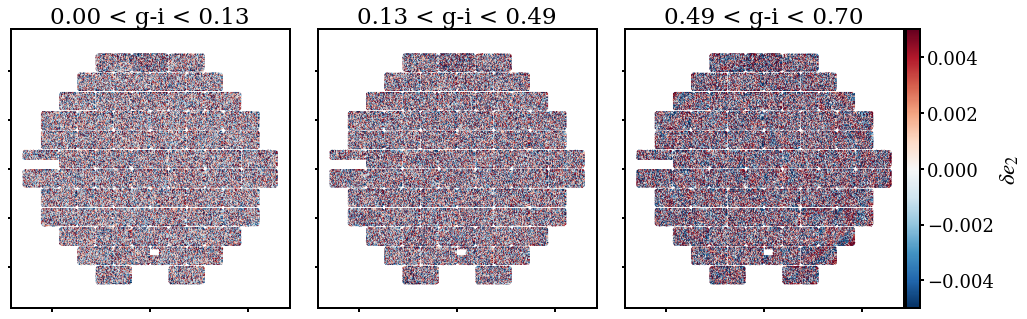

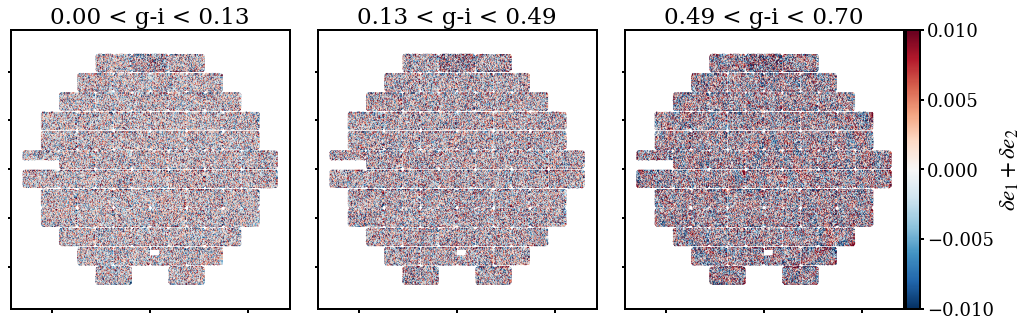

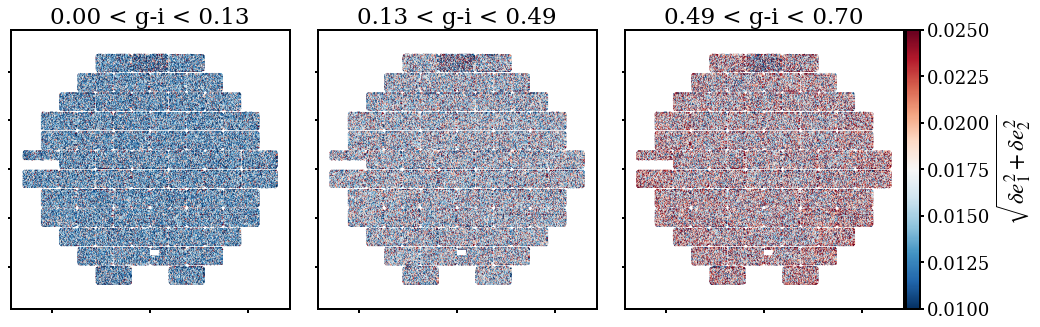

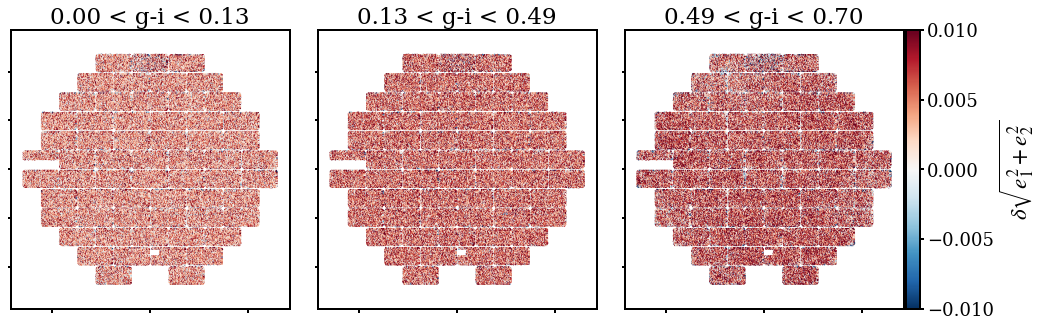

In [34]:
for res_type, res_tex, vmax in zip(res_types, res_texs, v_list):# color split dT/T residuals
    plttype = '3color-d%s'%res_type
    pltname = '%s_%s_%s_%s.pdf'%(filestem, band, plttype, ver)
    filename = os.path.join(plt_dir, pltname)

    plot_kw['subplot_dims'] = (1,3)
    plot_kw['figsize'] = (17,8)
    plot_kw['data'] = []
    plot_kw['title'] = []
    if res_type == 'de1+de2_sq':
        hexbin_kw['vmin'] = 0.01
    else:
        hexbin_kw['vmin'] = -vmax
    hexbin_kw['vmax'] = vmax
    hexbin_kw['cmap'] = 'RdBu_r'
    cbax_kw['ylabel'] = res_tex

    for cat_split, color_bin in zip(split_cats, color_bins):
        uu, vv, dres = calc_res(cat_split, res_type=res_type)
        hexbin_kw['x'], hexbin_kw['y'] = -vv, -uu
        plot_kw['data'].append(dres)
        plot_kw['title'].append('%.2f < g-i < %.2f'%(color_bin[0],color_bin[1]))

    plot_fp_hexbin(plot_kw)
    plt.savefig(filename, bbox_inches='tight', dpi=100)

In [35]:
# # color split de1 residuals
# res_type = 'e1'
# res_tex = r'$e_1$'
# plttype = '3color-d%s'%res_type
# pltname = '%s_%s_%s_%s.pdf'%(filestem, band, plttype, ver)
# filename = os.path.join(plt_dir, pltname)

# vmax=0.005
# plot_kw['subplot_dims'] = (1,3)
# plot_kw['figsize'] = (26,8)
# plot_kw['data'] = []
# plot_kw['title'] = []
# hexbin_kw['vmin'] = -vmax
# hexbin_kw['vmax'] = vmax
# hexbin_kw['cmap'] = 'RdBu_r'
# cbax_kw['ylabel'] = r'$ \delta %s$'%res_tex

# for cat_split, color_bin in zip(split_cats, y6_color_bins):
#     uu, vv, dres = calc_res(cat_split, res_type=res_type)
#     hexbin_kw['x'], hexbin_kw['y'] = -vv, -uu
#     plot_kw['data'].append(dres)
#     plot_kw['title'].append('%.2f < g-i < %.2f'%(color_bin[0],color_bin[1]))

# plot_fp_hexbin(plot_kw)
# plt.savefig(filename, dpi=100)

In [36]:
# # color split de2 residuals
# plttype = '3color-de2'
# pltname = '%s_%s_%s_%s.pdf'%(filestem, band, plttype, ver)
# filename = os.path.join(plt_dir, pltname)

# vmax=0.005
# plot_kw['subplot_dims'] = (1,3)
# plot_kw['figsize'] = (26,8)
# plot_kw['data'] = []
# plot_kw['title'] = []
# hexbin_kw['vmin'] = -vmax
# hexbin_kw['vmax'] = vmax
# hexbin_kw['cmap'] = 'RdBu_r'
# cbax_kw['ylabel'] = r'$ \delta e_2$'

# for cat_split, color_bin in zip(split_cats, y6_color_bins):
#     uu, vv, dres = calc_res(cat_split, res_type='e2')
#     hexbin_kw['x'], hexbin_kw['y'] = -vv, -uu
#     plot_kw['data'].append(dres)
#     plot_kw['title'].append('%.2f < g-i < %.2f'%(color_bin[0],color_bin[1]))

# plot_fp_hexbin(plot_kw)
# plt.savefig(filename, dpi=100)

In [37]:
# # color split de2 residuals
# plttype = '3color-de2'
# pltname = '%s_%s_%s_%s.pdf'%(filestem, band, plttype, ver)
# filename = os.path.join(plt_dir, pltname)

# vmax=0.005
# plot_kw['subplot_dims'] = (1,3)
# plot_kw['figsize'] = (26,8)
# plot_kw['data'] = []
# plot_kw['title'] = []
# hexbin_kw['vmin'] = -vmax
# hexbin_kw['vmax'] = vmax
# hexbin_kw['cmap'] = 'RdBu_r'
# cbax_kw['ylabel'] = r'$ \delta e_2$'

# for cat_split, color_bin in zip(split_cats, y6_color_bins):
#     uu, vv, dres = calc_res(cat_split, res_type='e2')
#     hexbin_kw['x'], hexbin_kw['y'] = -vv, -uu
#     plot_kw['data'].append(dres)
#     plot_kw['title'].append('%.2f < g-i < %.2f'%(color_bin[0],color_bin[1]))

# plot_fp_hexbin(plot_kw)
# plt.savefig(filename, dpi=100)

In [38]:
# numcol = len(y6_split_cats)
# fig, axs = plt.subplots(1,numcol, figsize=(23,6.5))

# vmin=-0.015
# vmax=-vmin
# # #Y3 plots
# # i = 0
# # for cat_split, color_bin in zip(y3_split_cats, y3_color_bins):
# #     ubins, vbins, counts, resbins = calc_2dbinned_res(cat_split, res_type='T', year='Y3', nbins=250)
    
# #     if i == numcol-1:
# #         cbar = True
# #     else:
# #         cbar = False
    
# #     plot_2dbinned_res(-ubins, -vbins, counts, resbins, ax=axs[0,i], vmin=vmin, vmax=vmax,
# #                     title='Y3, %.2f < g-i < %.2f'%(color_bin[0],color_bin[1]), cbar=cbar)
# #     i+=1

# #Y6 plots
# i = 0
# for cat_split, color_bin in zip(y6_split_cats, y6_color_bins):
#     ubins, vbins, counts, resbins = calc_2dbinned_res(cat_split, res_type='T', year='Y6', nbins=250)

#     if i == numcol-1:
#         cbar = True
#     else:
#         cbar = False
    
#     plot_2dbinned_res(-ubins, -vbins, counts, resbins, ax=axs[i], vmin=vmin, vmax=vmax,
#                     title='Y6, %.2f < g-i < %.2f'%(color_bin[0],color_bin[1]), cbar=cbar)
#     i+=1


# #     uu, vv = toFocal(band_cat['ccd'], band_cat['x'], band_cat['y'])
    
# #     dT = band_cat['obs_T'] - band_cat['piff_T']
# #     de1 = band_cat['obs_e1'] - band_cat['piff_e1']
# #     de2 = band_cat['obs_e2'] - band_cat['piff_e2']
    
# #     counts, ubins, vbins = np.histogram2d(uu, vv, bins=(100, 100))
# #     dT_bin, _, _ = np.histogram2d(uu, vv, weights=dT, bins=(ubins, vbins))
# #     de1_bin, _, _ = np.histogram2d(uu, vv, weights=de1, bins=(ubins, vbins))
# #     de2_bin, _, _ = np.histogram2d(uu, vv, weights=de2, bins=(ubins, vbins))

In [39]:
# numcol = len(y6_split_cats)
# fig, axs = plt.subplots(1,numcol, figsize=(23,6.5))

# vmin=-0.015
# vmax=-vmin
# #Y3 plots
# # i = 0
# # for cat_split, color_bin in zip(y3_split_cats, y3_color_bins):
# #     ubins, vbins, counts, resbins = calc_2dbinned_res(cat_split, res_type='T', year='Y3', nbins=250)
    
# #     if i == numcol-1:
# #         cbar = True
# #     else:
# #         cbar = False
    
# #     plot_2dbinned_res(-ubins, -vbins, counts, resbins, ax=axs[0,i], vmin=vmin, vmax=vmax,
# #                     title='Y3, %.2f < g-i < %.2f'%(color_bin[0],color_bin[1]), cbar=cbar)
# #     i+=1

# #Y6 plots
# i = 0
# for cat_split, color_bin in zip(y6_split_cats, y6_color_bins):
#     ubins, vbins, counts, resbins = calc_2dbinned_res(cat_split, res_type='T', year='Y6', nbins=250)

#     if i == numcol-1:
#         cbar = True
#     else:
#         cbar = False
    
#     plot_2dbinned_res(-ubins, -vbins, counts, resbins, ax=axs[i], vmin=vmin, vmax=vmax,
#                     title='Y6, %.2f < g-i < %.2f'%(color_bin[0],color_bin[1]), cbar=cbar)
#     i+=1

In [40]:
# numcol = len(y6_split_cats)
# fig, axs = plt.subplots(1,numcol, figsize=(23,6.5))

# vmin=-0.005
# vmax=-vmin
# rt = 'e1'

# #Y3 plots
# # i = 0
# # for cat_split, color_bin in zip(y3_split_cats, y3_color_bins):
# #     ubins, vbins, counts, resbins = calc_2dbinned_res(cat_split, res_type=rt, year='Y3', nbins=250)
    
# #     if i == numcol-1:
# #         cbar = True
# #     else:
# #         cbar = False
    
# #     plot_2dbinned_res(-ubins, -vbins, counts, resbins, ax=axs[0,i], vmin=vmin, vmax=vmax, restype=rt,
# #                     title='Y3, %.2f < g-i < %.2f'%(color_bin[0],color_bin[1]), cbar=cbar)
# #     i+=1

# #Y6 plots
# i = 0
# for cat_split, color_bin in zip(y6_split_cats, y6_color_bins):
#     ubins, vbins, counts, resbins = calc_2dbinned_res(cat_split, res_type=rt, year='Y6', nbins=250)

#     if i == numcol-1:
#         cbar = True
#     else:
#         cbar = False
    
#     plot_2dbinned_res(-ubins, -vbins, counts, resbins, ax=axs[i], vmin=vmin, vmax=vmax, restype=rt,
#                     title='Y6, %.2f < g-i < %.2f'%(color_bin[0],color_bin[1]), cbar=cbar)
#     i+=1

In [41]:
# numcol = len(y6_split_cats)
# fig, axs = plt.subplots(1,numcol, figsize=(23,6.5))

# vmin=-0.005
# vmax=-vmin
# rt = 'e2'
# #Y3 plots
# # i = 0
# # for cat_split, color_bin in zip(y3_split_cats, y3_color_bins):
# #     ubins, vbins, counts, resbins = calc_2dbinned_res(cat_split, res_type=rt, year='Y3', nbins=250)
    
# #     if i == numcol-1:
# #         cbar = True
# #     else:
# #         cbar = False
    
# #     plot_2dbinned_res(-ubins, -vbins, counts, resbins, ax=axs[0,i], vmin=vmin, vmax=vmax, restype=rt,
# #                     title='Y3, %.2f < g-i < %.2f'%(color_bin[0],color_bin[1]), cbar=cbar)
# #     i+=1

# #Y6 plots
# i = 0
# for cat_split, color_bin in zip(y6_split_cats, y6_color_bins):
#     ubins, vbins, counts, resbins = calc_2dbinned_res(cat_split, res_type=rt, year='Y6', nbins=250)

#     if i == numcol-1:
#         cbar = True
#     else:
#         cbar = False
    
#     plot_2dbinned_res(-ubins, -vbins, counts, resbins, ax=axs[i], vmin=vmin, vmax=vmax, restype=rt,
#                     title='Y6, %.2f < g-i < %.2f'%(color_bin[0],color_bin[1]), cbar=cbar)
#     i+=1

In [42]:
# numcol = len(y6_split_cats)
# fig, axs = plt.subplots(1,numcol, figsize=(23,6.5))

# vmin=-0.01
# vmax=-vmin
# rt = 'e1+e2'
# #Y3 plots
# # i = 0
# # for cat_split, color_bin in zip(y3_split_cats, y3_color_bins):
# #     ubins, vbins, counts, resbins = calc_2dbinned_res(cat_split, res_type=rt, year='Y3', nbins=250)
    
# #     if i == numcol-1:
# #         cbar = True
# #     else:
# #         cbar = False
    
# #     plot_2dbinned_res(-ubins, -vbins, counts, resbins, ax=axs[0,i], vmin=vmin, vmax=vmax, restype=rt,
# #                     title='Y3, %.2f < g-i < %.2f'%(color_bin[0],color_bin[1]), cbar=cbar)
# #     i+=1

# #Y6 plots
# i = 0
# for cat_split, color_bin in zip(y6_split_cats, y6_color_bins):
#     ubins, vbins, counts, resbins = calc_2dbinned_res(cat_split, res_type=rt, year='Y6', nbins=250)

#     if i == numcol-1:
#         cbar = True
#     else:
#         cbar = False
    
#     plot_2dbinned_res(-ubins, -vbins, counts, resbins, ax=axs[i], vmin=vmin, vmax=vmax, restype=rt,
#                     title='Y6, %.2f < g-i < %.2f'%(color_bin[0],color_bin[1]), cbar=cbar)
#     i+=1

In [43]:
# numcol = len(y6_split_cats)
# fig, axs = plt.subplots(1,numcol, figsize=(23,6.5))

# vmin=0.007
# vmax=0.03
# rt = 'e1+e2_sq'
# #Y3 plots
# # i = 0
# # for cat_split, color_bin in zip(y3_split_cats, y3_color_bins):
# #     ubins, vbins, counts, resbins = calc_2dbinned_res(cat_split, res_type=rt, year='Y3', nbins=250)
    
# #     if i == numcol-1:
# #         cbar = True
# #     else:
# #         cbar = False
    
# #     plot_2dbinned_res(-ubins, -vbins, counts, resbins, ax=axs[0,i], vmin=vmin, vmax=vmax, restype=rt,
# #                     title='Y3, %.2f < g-i < %.2f'%(color_bin[0],color_bin[1]), cbar=cbar)
# #     i+=1

# #Y6 plots
# i = 0
# for cat_split, color_bin in zip(y6_split_cats, y6_color_bins):
#     ubins, vbins, counts, resbins = calc_2dbinned_res(cat_split, res_type=rt, year='Y6', nbins=250)

#     if i == numcol-1:
#         cbar = True
#     else:
#         cbar = False
    
#     plot_2dbinned_res(-ubins, -vbins, counts, resbins, ax=axs[i], vmin=vmin, vmax=vmax, restype=rt,
#                     title='Y6, %.2f < g-i < %.2f'%(color_bin[0],color_bin[1]), cbar=cbar)
#     i+=1